#Requirements

In [ ]:
# 네이버 나눔 폰트 설치 
# 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,210 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 156210 files and d

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 85.2 MB/s 
     |████████████████████████████████| 596 kB 70.1 MB/s 
     |████████████████████████████████| 6.5 MB 80.9 MB/s 
     |████████████████████████████████| 77 kB 8.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import json
import random
import os
import torch
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AdamW

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

#Reproducibility

In [ ]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [ ]:
seed_everything(42)

#Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#데이터 준비 및 EDA

In [ ]:
DATA_PATH = "/content/gdrive/MyDrive/k-digital-goorm-3-korean-mrc/"

In [ ]:
with open(DATA_PATH + "train.json", 'rb') as f:
    klue_dict = json.load(f)

In [ ]:
klue_dict.

{'news_category': '종합',
 'paragraphs': [{'context': '올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, 강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400㎜로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다.',
   'qas': [{'answers': [{'answer_start': 478, 'text': '한 달가량'},
      {'answer_start': 478, 'text': '한 달'}],
     'guid': '798db07f0b9046759deed9d4a35ce31e',
     'question': '북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?'}]}]

In [ ]:
def read_klue(path):
    with open(path, 'rb') as f:
        klue_dict = json.load(f)

    categories = [] # 카테고리 추가
    contexts = []
    questions = []
    answers = []

    for group in tqdm(klue_dict['data']):
        category = group["news_category"]  # for EDA
        
        for passage in group['paragraphs']:
            context = passage['context']

            for qa in passage['qas']:
                question = qa['question']

                for answer in qa['answers']: # anwer_start 정보는 다음의 함수에서 다뤄줄 것

                    # 모은 정보들 list 에 추가
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
                    categories.append(category)
  

    return categories, contexts, questions, answers

현재 정답이 context에서 시작하는 위치(answer_start)만 있기 때문에 끝나는 위치도 구해보겠습니다.

In [ ]:
def add_end_idx(answers, contexts):
  
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']

        end_idx = start_idx + len(gold_text)

        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx

        # (아마) 띄어쓰기 고려
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1

        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2

이제 데이터에 정답의 시작하는 위치, 끝나는 위치가 포함되었습니다.

In [ ]:
# 위의 두 함수들 적용해서 각 정보들 list 로 담아냄 
train_categories, train_contexts, train_questions, train_answers = read_klue(DATA_PATH + "train.json")
add_end_idx(train_answers, train_contexts)

  0%|          | 0/9789 [00:00<?, ?it/s]



*   tokenization 진행 전 데이터 분포




In [ ]:
train_df = pd.DataFrame()
train_df['Categories'] = train_categories
train_df['Contexts'] = train_contexts
train_df['Questions'] = train_questions
train_df['Answers'] = train_answers

In [ ]:
train_df.describe(include="all")

,Categories,Contexts,Questions,Answers
count,12667,17663,17663,17663
unique,33,10434,12037,17463
top,종합,신격호 롯데그룹 총괄회장(94)이 롯데그룹 경영권 분쟁과 관련해 장남인 신동주 전 ...,"롯데의 경영권 후계자 임명과 관련, 신 총괄회장과의 최초 공개 인터뷰가 있었던 장소는?","{'text': '2008년', 'answer_start': 0, 'answer_e..."
freq,2425,11,11,3


In [ ]:
train_df.head()

,Categories,Contexts,Questions,Answers
0,종합,올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,"{'text': '한 달가량', 'answer_start': 478, 'answer..."
1,종합,올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,"{'text': '한 달', 'answer_start': 478, 'answer_e..."
2,경제,부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스...,지능형 생산자동화 기반기술을 개발중인 스타트업은?,"{'text': '삼보테크놀로지', 'answer_start': 1422, 'ans..."
3,None,시범 경기에서는 16이닝을 던져 15실점을 기록하는 등 성적이 좋지 않았지만 본인으...,개막전에서 3안타 2실점을 기록해서 패한 선수는?,"{'text': '와쿠이 히데아키', 'answer_start': 107, 'ans..."
4,생활경제,유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘검...,컵라면 매출에서 불닭볶음면을 이긴 상품은?,"{'text': '‘교동반점 짬뽕’', 'answer_start': 408, 'an..."


#중복

In [ ]:
Answers_str = train_df['Answers'].apply(str) # for checking duplicates
temp_train_df = train_df.copy()
temp_train_df["Answers"] = Answers_str
temp_train_df.head()

,Categories,Contexts,Questions,Answers
0,종합,올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,"{'text': '한 달가량', 'answer_start': 478, 'answer..."
1,종합,올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,"{'text': '한 달', 'answer_start': 478, 'answer_e..."
2,경제,부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스...,지능형 생산자동화 기반기술을 개발중인 스타트업은?,"{'text': '삼보테크놀로지', 'answer_start': 1422, 'ans..."
3,None,시범 경기에서는 16이닝을 던져 15실점을 기록하는 등 성적이 좋지 않았지만 본인으...,개막전에서 3안타 2실점을 기록해서 패한 선수는?,"{'text': '와쿠이 히데아키', 'answer_start': 107, 'ans..."
4,생활경제,유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘검...,컵라면 매출에서 불닭볶음면을 이긴 상품은?,"{'text': '‘교동반점 짬뽕’', 'answer_start': 408, 'an..."


In [ ]:
# duplicates
print(len(temp_train_df[temp_train_df.duplicated(keep=False)].sort_values("Contexts")))
temp_train_df[temp_train_df.duplicated(keep=False)].sort_values("Contexts")

10


,Categories,Contexts,Questions,Answers
10923,기획,"‘기업공개(IPO) 수 105건, 조달금액 7억3100만유로(약 1조900억원).’...",자기자본을 가지고 금융거래하는 것을 막은 미국의 법안은?,"{'text': '한국경제신문', 'answer_start': 288, 'answe..."
10924,기획,"‘기업공개(IPO) 수 105건, 조달금액 7억3100만유로(약 1조900억원).’...",자기자본을 가지고 금융거래하는 것을 막은 미국의 법안은?,"{'text': '한국경제신문', 'answer_start': 288, 'answe..."
14464,None,"중동신도시(中洞新都市)는 경기도 부천시 중동, 상동 일대에 조성된 신도시이다. 중동...",중동신도시 개발에 기관 몇 곳이 적극적으로 뛰어들었나?,"{'text': '3', 'answer_start': 386, 'answer_end..."
14466,None,"중동신도시(中洞新都市)는 경기도 부천시 중동, 상동 일대에 조성된 신도시이다. 중동...",중동신도시 개발에 기관 몇 곳이 적극적으로 뛰어들었나?,"{'text': '3', 'answer_start': 386, 'answer_end..."
1403,금융,직장인 H씨는 연말에 받는 1000만원가량의 성과급과 만기가 된 적금 2500만원을...,지방은행이 특별판매를 하는 이유는?,"{'text': '연말에 만기가 돌아오는 예금 가입자들을 유치하기 위해서', 'an..."
1406,금융,직장인 H씨는 연말에 받는 1000만원가량의 성과급과 만기가 된 적금 2500만원을...,지방은행이 특별판매를 하는 이유는?,"{'text': '연말에 만기가 돌아오는 예금 가입자들을 유치하기 위해서', 'an..."
11140,산업,코오롱그룹 IT서비스 전문기업 코오롱베니트(대표 이진용)가 오는 20일부터 24일까...,Smart Construction & IoT의 현황과 전망'을 주제로한 솔루션 구축...,"{'text': '20일', 'answer_start': 36, 'answer_en..."
11142,산업,코오롱그룹 IT서비스 전문기업 코오롱베니트(대표 이진용)가 오는 20일부터 24일까...,Smart Construction & IoT의 현황과 전망'을 주제로한 솔루션 구축...,"{'text': '20일', 'answer_start': 36, 'answer_en..."
1260,None,흑표당은 스토클리 카마이클이 주도하는 학생 비폭력 협력회와 합병되었다. 1968년 ...,흑표당이 실현하고자 했던 말콤X의 사상은?,"{'text': '자기방어 철학', 'answer_start': 281, 'answ..."
1262,None,흑표당은 스토클리 카마이클이 주도하는 학생 비폭력 협력회와 합병되었다. 1968년 ...,흑표당이 실현하고자 했던 말콤X의 사상은?,"{'text': '자기방어 철학', 'answer_start': 281, 'answ..."


#비슷한 의미의 Question

In [ ]:
temp_train_df[temp_train_df.duplicated(["Questions"],keep=False)].sort_values("Contexts")

,Categories,Contexts,Questions,Answers
15074,None,"""시간이동""은 미국의 방송사 ABC의 텔레비전 드라마 시리즈 로스트의 시즌 프리미어...",ABC에서 방영되는 '시간이동'의 장르는?,"{'text': '텔레비전 드라마', 'answer_start': 21, 'answ..."
15075,None,"""시간이동""은 미국의 방송사 ABC의 텔레비전 드라마 시리즈 로스트의 시즌 프리미어...",ABC에서 방영되는 '시간이동'의 장르는?,"{'text': '드라마', 'answer_start': 26, 'answer_en..."
14154,None,"""아자르야""라는 이름은 ""여호와는 나의 힘이다""라는 의미를 가지고 있다. 예루살렘 ...",아자르야에게 패배한 아랍인들의 거주지 중 아자르야가 새롭게 성을 쌓은 지역은 어디인가?,"{'text': '팔레스타인', 'answer_start': 189, 'answer..."
14153,None,"""아자르야""라는 이름은 ""여호와는 나의 힘이다""라는 의미를 가지고 있다. 예루살렘 ...",아자르야에게 패배한 아랍인들의 거주지 중 아자르야가 새롭게 성을 쌓은 지역은 어디인가?,"{'text': '블레셋(팔레스타인) 지역', 'answer_start': 185,..."
14152,None,"""아자르야""라는 이름은 ""여호와는 나의 힘이다""라는 의미를 가지고 있다. 예루살렘 ...",아자르야에게 패배한 아랍인들의 거주지 중 아자르야가 새롭게 성을 쌓은 지역은 어디인가?,"{'text': '블레셋(팔레스타인)', 'answer_start': 185, 'a..."
...,...,...,...,...
4350,None,"힐은 전쟁중에 논쟁을 피하지 못했다. 병약한 체질이라서 여러 번 병치레를 했기에, ...",남군의 소장들 중 힐이 가장 뛰어난 사람이라고 언급한 인물은?,"{'text': '로버트 E. 리', 'answer_start': 820, 'ans..."
9612,경제,＃1. 중국 항저우에 사는 진옌 씨(37)는 다음달 춘제(春節·중국 설) 연휴에 부...,현재 중국인 관광객이 한국을 재방문하는 비율은 약 몇 %인가요?,"{'text': '30', 'answer_start': 1092, 'answer_e..."
9611,경제,＃1. 중국 항저우에 사는 진옌 씨(37)는 다음달 춘제(春節·중국 설) 연휴에 부...,현재 중국인 관광객이 한국을 재방문하는 비율은 약 몇 %인가요?,"{'text': '30%', 'answer_start': 1092, 'answer_..."
9610,경제,＃1. 중국 항저우에 사는 진옌 씨(37)는 다음달 춘제(春節·중국 설) 연휴에 부...,일본이 최근 취한 비자완화 조치 대상이 되는 유커는?,"{'text': '상당한 고소득자와 그 가족', 'answer_start': 870..."


#Domain Distribution

In [ ]:
# 한국어 데이터 plot - category 관련
category_df = temp_train_df['Categories'].value_counts().rename_axis('unique_values').reset_index(name='counts')

In [ ]:
category_df.head()

,unique_values,counts
0,종합,2425
1,사회,945
2,산업섹션,789
3,국제,781
4,부동산,755


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


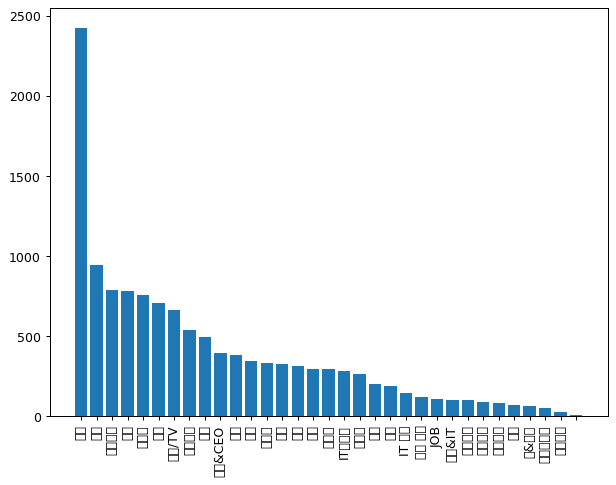

In [ ]:
warnings.filterwarnings("ignore")
figure(figsize=(8, 6), dpi=90)
plt.bar(category_df.unique_values, category_df.counts)
plt.xticks(rotation=90)
plt.show()

#문장 길이

#**Contexts**

In [ ]:
def get_length(df):
  context_list = []
  question_list = []
  context_question_list = []
  answer_list = []

  for _, row in train_df.iterrows():
    context_len = len(row.Contexts)
    question_len = len(row.Questions)

    context_list.append(context_len)
    question_list.append(question_len)
    context_question_list.append(context_len + question_len)

    try:
      answer_length = len(row.Answers["text"])
      answer_list.append(answer_length)

    except: 
      pass

  return context_list, question_list, context_question_list, answer_list

In [ ]:
train_context_list, train_question_list, train_context_question_list, train_answer_list = get_length(train_df)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


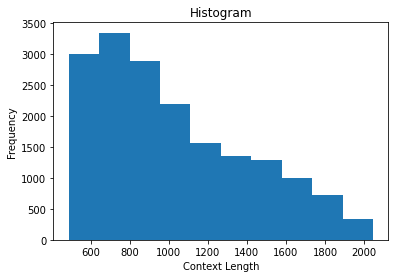

In [ ]:
n, bins, patches=plt.hist(train_context_list)
plt.xlabel("Context Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

#**Questions**

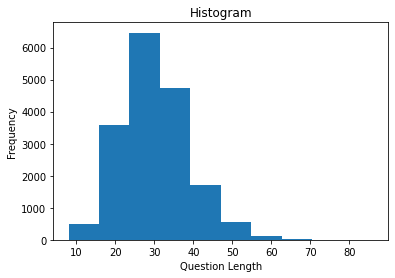

In [ ]:
n, bins, patches=plt.hist(train_question_list)
plt.xlabel("Question Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

#**Contexts** + **Questions**

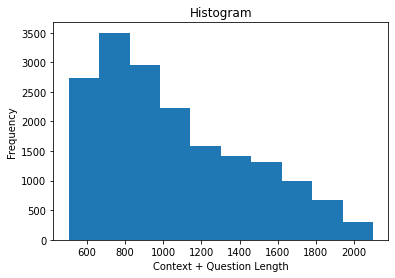

In [ ]:
n, bins, patches=plt.hist(train_context_question_list)
plt.xlabel("Context + Question Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

#**Answers**

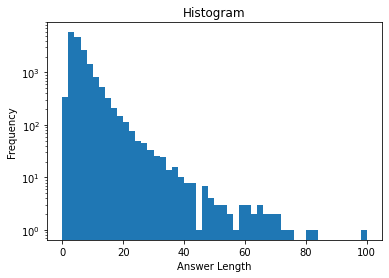

In [ ]:
n, bins, patches=plt.hist(train_answer_list, bins=50, log=True, range=[0,100])
plt.xlabel("Answer Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

#**전처리**

In [ ]:
# pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
pretrained_vocabs = tokenizer.get_vocab()

In [ ]:
# # sort by token id 
dict(sorted(pretrained_vocabs.items(), key=lambda item: item[1]))

{'[PAD]': 0,
 '[UNK]': 1,
 '[CLS]': 2,
 '[SEP]': 3,
 '[MASK]': 4,
 '!': 5,
 '"': 6,
 '#': 7,
 '$': 8,
 '%': 9,
 '&': 10,
 "'": 11,
 '(': 12,
 ')': 13,
 '*': 14,
 '+': 15,
 ',': 16,
 '-': 17,
 '.': 18,
 '/': 19,
 '0': 20,
 '1': 21,
 '2': 22,
 '3': 23,
 '4': 24,
 '5': 25,
 '6': 26,
 '7': 27,
 '8': 28,
 '9': 29,
 ':': 30,
 ';': 31,
 '<': 32,
 '=': 33,
 '>': 34,
 '?': 35,
 '@': 36,
 'A': 37,
 'B': 38,
 'C': 39,
 'D': 40,
 'E': 41,
 'F': 42,
 'G': 43,
 'H': 44,
 'I': 45,
 'J': 46,
 'K': 47,
 'L': 48,
 'M': 49,
 'N': 50,
 'O': 51,
 'P': 52,
 'Q': 53,
 'R': 54,
 'S': 55,
 'T': 56,
 'U': 57,
 'V': 58,
 'W': 59,
 'X': 60,
 'Y': 61,
 'Z': 62,
 '[': 63,
 ']': 64,
 '^': 65,
 '_': 66,
 '`': 67,
 'a': 68,
 'b': 69,
 'c': 70,
 'd': 71,
 'e': 72,
 'f': 73,
 'g': 74,
 'h': 75,
 'i': 76,
 'j': 77,
 'k': 78,
 'l': 79,
 'm': 80,
 'n': 81,
 'o': 82,
 'p': 83,
 'q': 84,
 'r': 85,
 's': 86,
 't': 87,
 'u': 88,
 'v': 89,
 'w': 90,
 'x': 91,
 'y': 92,
 'z': 93,
 '{': 94,
 '|': 95,
 '}': 96,
 '~': 97,
 '²': 98,

#**Special** **Tokens**
<tokenization 후 얻을 수 있는 input_ids 에 대한 token 정보>

*   '[PAD]': 0,
*   '[UNK]': 1, -> 기억해놓기


*   '[CLS]': 2
*   '[SEP]': 3,


*   '[MASK]': 4,








In [ ]:
context = "올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, 강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400㎜로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다."
question = "북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?"

In [ ]:
tokenizer.convert_tokens_to_string(tokenizer.tokenize(context, question)) # context 다음 바로 question 이 오는 형태

'올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다. 17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2 ~ 3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다. 장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20 ~ 21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24 ~ 25일이었으며 장마기간은 32일, 강수일수는 17. 2일이었다. 기상청은 올해 장마기간의 평균 강수량이 350 ~ 400㎜로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다. 북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?'

In [ ]:
# tokenizer.convert_tokens_to_ids(tokenizer.tokenize(context, question))
tokenizer(context, question) 
# [CLS] token: 2
#위의 코드랑 확인해보면 3이 [SEP] token 으로 쓰였다는걸 알 수 있음

{'input_ids': [2, 1446, 22555, 11477, 2116, 3932, 2210, 6530, 27135, 3670, 2367, 2062, 18, 3671, 886, 9775, 16311, 2073, 12982, 2178, 2062, 15513, 3309, 3681, 798, 2073, 5277, 1041, 2678, 11477, 2116, 3670, 2651, 4016, 28674, 18, 3932, 2210, 11945, 2170, 3881, 2460, 6530, 7831, 1060, 10526, 2170, 1513, 2259, 11477, 2165, 2020, 2079, 3979, 6233, 3814, 6530, 24028, 1116, 12468, 17552, 2170, 24902, 3802, 2178, 2116, 23772, 31369, 5844, 2170, 3911, 3569, 2170, 10760, 2205, 2259, 1039, 2073, 1187, 2116, 5740, 2062, 18, 4364, 2079, 11477, 2259, 18673, 2178, 2062, 22, 97, 23, 2210, 16, 3736, 2178, 4000, 4051, 5947, 3670, 2367, 2062, 18, 11477, 2259, 19880, 2062, 2219, 2470, 1174, 18956, 26797, 2145, 1891, 2398, 1322, 2399, 2470, 22152, 2128, 2292, 2097, 26797, 2052, 4026, 4605, 2496, 2259, 11477, 2165, 2020, 27135, 4848, 2259, 1187, 2138, 936, 4538, 18, 11477, 2165, 2020, 2073, 3801, 2210, 6530, 1060, 7831, 7755, 6233, 12314, 4795, 3619, 2210, 2678, 3690, 25848, 2097, 4997, 18787, 2299, 2118,

In [ ]:
# 1 in tokenizer(context, question)['input_ids'] # 일단 위의 예시의 경우 unknown token 없음



*   input_ids: tokenization 결과 + SPECIAL tokens 추가된 형태
*   token_type_ids: context 가 0, question이 1

*   attention_mask: 모두 1

이제 데이터들을 토큰화 해보겠습니다.

truncation은 모델에 입력되는 길이가 모델에 허용되는 최대 입력 길이보다 클 경우 모델의 최대 입력 길이로 자르는 역할을 합니다.

반면 padding은 모델에 입력되는 길이가 모델에 허용되는 최대 입력 길이보다 작을 경우 모델의 최대 입력 길이까지 채우는 역할을 합니다.

토큰화가 다 진행되었다면 다음으로 raw Context의 answer의 시작/종료 위치를, 토큰화된 context 안에서 answer의 시작/종료 위치로 바꿔야 합니다. 이를 위해 char_to_token을 사용하였는데, 이는 '원래의 문자열'에서 토큰의 인덱스를 가져오는 역할을 합니다.

char_to_token = Get the index of the token in the encoded output comprising a character in the original string for a sequence of the batch.



In [ ]:
train_df.head(2)

,Categories,Contexts,Questions,Answers
0,종합,올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,"{'text': '한 달가량', 'answer_start': 478, 'answer..."
1,종합,올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도...,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,"{'text': '한 달', 'answer_start': 478, 'answer_e..."


#Dataset (Tokenization 포함)

In [ ]:
# collate function 사용 안했음
class KlueDataset(Dataset):

    def __init__(self, contexts, questions, answers, model_max_position_embedings, tokenizer):
        self.tokenizer = tokenizer
        self.answers = answers
        self.questions = questions
        self.contexts = contexts
        self.model_max_position_embedings = model_max_position_embedings
        print("Tokenizing ...")
        self.encodings = self.tokenizer(self.contexts, 
                                        self.questions, # contexts + questions 가 tokenization 될 것 (answer는 x)
                                        max_length=self.model_max_position_embedings, # 이 길이만큼의 토큰 수만 수용
                                        truncation=True,
                                        padding="max_length",
                                        return_token_type_ids=False)
        print("Done !!!")
        self.add_token_positions() # 뒤의 함수



    # tokenized 된 contexts 에서 answer 의 시작, 끝 위치를 찾아줌
    def add_token_positions(self):
        start_positions = []
        end_positions = []

        for i in range(len(self.answers)): # answers = tokenization 되지 않은 상태                              
            # char_to_token = Get the index of the token in the encoded output comprising a character in the original string
            # cf. self.encodings = tokenized 된 결과
            # 밑 코드들: tokenized 된 context 안에서의 answer의 시작/종료 위치를 가져옴
            # cf.answer_start, answer_end 의 경우 original text 에서 정답의 시작, 끝 index 임 (위의 df 참고)
            start_positions.append(self.encodings.char_to_token(i, self.answers[i]['answer_start']))
            end_positions.append(self.encodings.char_to_token(i, self.answers[i]['answer_end'] - 1)) # 아마 python index의 특징 때문에

            # import pdb
            # pdb.set_trace()

            # position 값이 None 값이라면 (이상적으로는 1개가 나와야 함), 
            # answer가 포함된 context가 (tokenization 과정에서) 잘렸다는 의미
            if start_positions[-1] is None:
                start_positions[-1] = self.model_max_position_embedings
            if end_positions[-1] is None:
                end_positions[-1] = self.model_max_position_embedings

        # self.encodings 에 start, end positions 추가
        self.encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

    # data 전체 (토큰화 전)
    def get_data(self):
        return {"contexts":self.contexts, 'questions':self.questions, 'answers':self.answers}
    
    # tokenized 된 결과 확인 
    def __getitem__(self, idx):
        return {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
    
    # data 개수
    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
train_dataset = KlueDataset(train_contexts, train_questions, train_answers, 512, tokenizer)

Tokenizing ...
Done !!!


#Token 개수 & Unknown token 개수 확인

In [ ]:
# padding 제외 각 record의 총 token 개수 (나머지 cls, unk, sep 은 포함)
def get_token_nums(dataset): 
  length_list = []
  for i in range(len(dataset)):
    length_list.append(dataset.__getitem__(i)["input_ids"].count_nonzero().item())
  return length_list

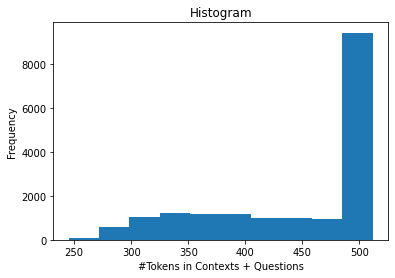

In [ ]:
train_length_list = get_token_nums(train_dataset)

n, bins, patches=plt.hist(train_length_list)
plt.xlabel("#Tokens in Contexts + Questions")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

In [ ]:
def get_one_nums(dataset): 
  one_num_list = []
  for i in range(len(dataset)):
    record_token_ids = dataset.__getitem__(i)["input_ids"]
    num_ones = (record_token_ids == 1.).sum(dim=0).item()
    one_num_list.append(num_ones)
  return one_num_list

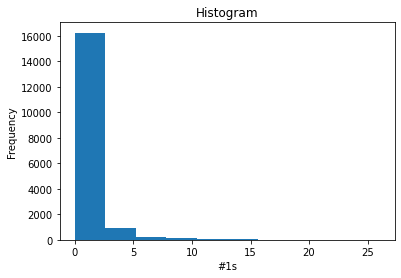

In [ ]:
# unknown tokens
train_one_num_list = get_one_nums(train_dataset)

n, bins, patches=plt.hist(train_one_num_list)
plt.xlabel("#1s")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

In [ ]:
train_one_num_list.count(0) / len(train_one_num_list)

0.7576855573798336

cf. 밑의 코드들은 512로 자르지 않았을 경우

In [ ]:
# 각 record 별 context + question (+ cls token) 길이 살펴보기 위해 max length 를 2000으로 잡아줌
temp_train_dataset = KlueDataset(train_contexts, train_questions, train_answers, 2000, tokenizer)

Tokenizing ...
Done !!!


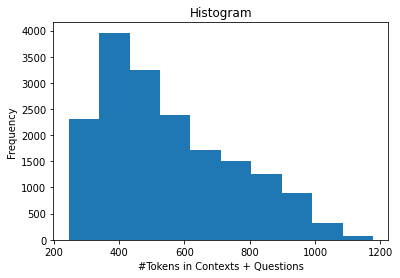

In [ ]:
temp_train_length_list = get_token_nums(temp_train_dataset)

n, bins, patches=plt.hist(temp_train_length_list)
plt.xlabel("#Tokens in Contexts + Questions")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

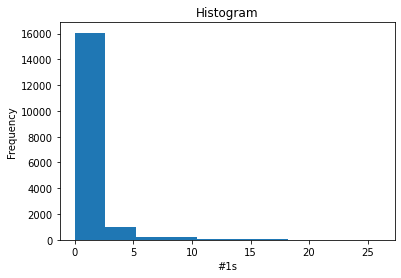

In [ ]:
# unknown tokens
temp_train_one_num_list = get_one_nums(temp_train_dataset)

n, bins, patches=plt.hist(temp_train_one_num_list)
plt.xlabel("#1s")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

In [ ]:
temp_train_one_num_list.count(0)

12951

#모델 학습 (Dataloader 코드 runner 안에 포함)
우선 학습에 사용할 모델을 불러오겠습니다.

모델을 불러오면 경고가 발생하는 데 이는 BertForQuestionAnswering를 fine-tuning 하기 전에는 모델의 성능이 좋지 않을 것이라고 알려줍니다.

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained("klue/bert-base")

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model chec

In [ ]:
EPOCH = 3
LEARNING_RATE = 5e-5
BATCH_SIZE = 5 # 5개 data 보고 parmaeter update

학습할 때는 모델에 context+question을 인코딩한 input_ids, attention_mask, start_positions, end_positions가 input으로 들어갑니다.

In [ ]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
def train_runner(model, dataset, batch_size, num_train_epochs, learning_rate):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    model.to(device)
    model.train()
    train_dataloader = DataLoader(dataset=dataset, batch_size=batch_size)
    global_total_step = len(train_dataloader) * num_train_epochs
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0)
    total_steps = len(train_dataloader) * num_train_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
    print("TRAIN START")
    with tqdm(total=global_total_step, unit='step') as t:
        total = 0
        total_loss = 0
        for epoch in range(num_train_epochs):
            for batch in train_dataloader:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                start_positions = batch['start_positions'].to(device)
                end_positions = batch['end_positions'].to(device)
                outputs = model(input_ids,
                             attention_mask=attention_mask,
                             start_positions=start_positions,
                             end_positions=end_positions)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                scheduler.step()
                
                batch_loss = loss.item() * len(input_ids)
                total += len(input_ids)
                total_loss += batch_loss
                global_total_step += 1
                t.set_postfix(loss="{:.6f}".format(total_loss / total), batch_loss="{:.6f}".format(batch_loss))
                t.update(1)
                
                del input_ids
                del attention_mask
                del start_positions
                del end_positions
                del outputs
                del loss
    model.save_pretrained("./klue_output_model")
    print("TRAIN END")

In [ ]:
train_runner(model,train_dataset, BATCH_SIZE, EPOCH, LEARNING_RATE)

TRAIN START


  0%|          | 0/10599 [00:00<?, ?step/s]

TRAIN END


#Test 데이터 준비 및 EDA

In [ ]:
def read_test_klue(path):
    with open(path, 'rb') as f:
        klue_dict = json.load(f)

    categories = [] # 카테고리 추가
    contexts = []
    questions = []
    guids = []  # guid 추가

    for group in tqdm(klue_dict['data']):
        category = group["news_category"] # for EDA

        for passage in group['paragraphs']:
            context = passage['context']

            for qa in passage['qas']:
                question = qa['question']
                guid = qa['guid']

                # 모은 정보들 list 에 추가
                contexts.append(context)
                questions.append(question)
                guids.append(guid)
                categories.append(category)


    return categories, contexts, questions, guids

In [ ]:
test_categories, test_contexts, test_questions, test_guids = read_test_klue(DATA_PATH + "test.json")

  0%|          | 0/3709 [00:00<?, ?it/s]



*   tokenization 진행 전 데이터 분포



In [ ]:
test_df = pd.DataFrame()
test_df['Categories'] = test_categories
test_df['Contexts'] = test_contexts
test_df['Questions'] = test_questions
test_df['guid'] = test_guids

In [ ]:
test_df.describe(include="all")

,Categories,Contexts,Questions,guid
count,2818,4008,4008,4008
unique,32,3841,4008,4008
top,종합,자유 연상(심리역동이론)은 정신분석학에 기반한 심리치료에 사용되는 기술 로서 지그문...,말라카이트에서 나온 색깔을 사용한 에디션은?,d14cb73158624cf094c546d856fd3c80
freq,515,3,1,1


#중복, 비슷한 의미의 Question X

In [ ]:
# duplicates
print(len(test_df[test_df.duplicated(keep=False)].sort_values("Contexts")))
test_df[test_df.duplicated(keep=False)].sort_values("Contexts")

0


,Categories,Contexts,Questions,guid


In [ ]:
test_df[test_df.duplicated(["Questions"],keep=False)].sort_values("Contexts")

,Categories,Contexts,Questions,guid


#Domain Distribution:Train 과 비슷

In [ ]:
# 한국어 데이터 plot - category 관련
test_category_df = test_df['Categories'].value_counts().rename_axis('unique_values').reset_index(name='counts')

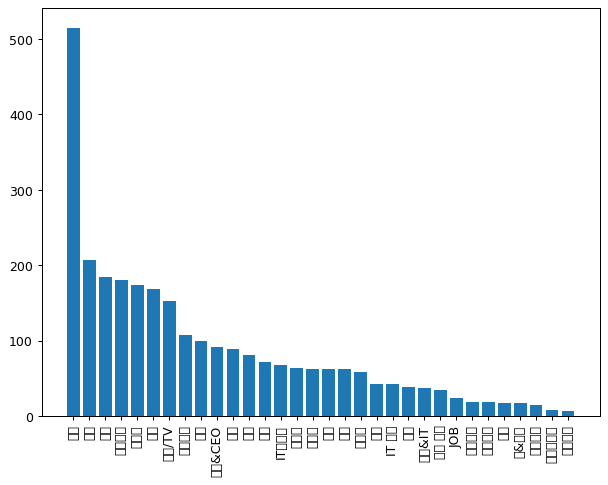

In [ ]:
warnings.filterwarnings("ignore")
figure(figsize=(8, 6), dpi=90)
plt.bar(test_category_df.unique_values, test_category_df.counts)
plt.xticks(rotation=90)
plt.show()

#문장 길이

#Contexts

In [ ]:
test_context_list, test_question_list, test_context_question_list, _ = get_length(test_df)

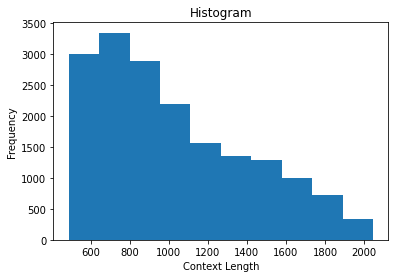

In [ ]:
n, bins, patches=plt.hist(test_context_list)
plt.xlabel("Context Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

#Questions

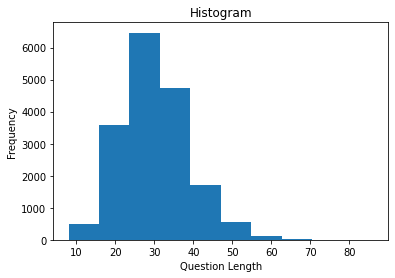

In [ ]:
n, bins, patches=plt.hist(test_question_list)
plt.xlabel("Question Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

#Contexts + Questions

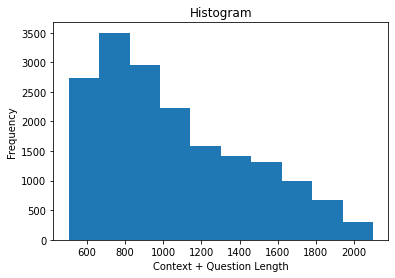

In [ ]:
n, bins, patches=plt.hist(test_context_question_list)
plt.xlabel("Context + Question Length")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

In [ ]:
# collate function 사용 안했음
class Test_KlueDataset(Dataset):

    def __init__(self, contexts, questions, guids, model_max_position_embedings, tokenizer):
        self.tokenizer = tokenizer
        self.questions = questions
        self.contexts = contexts
        self.guids = guids
        self.model_max_position_embedings = model_max_position_embedings
        print("Tokenizing ...")
        self.encodings = self.tokenizer(self.contexts, 
                                        self.questions, # contexts + questions 가 tokenization 될 것 (answer는 x)
                                        max_length=self.model_max_position_embedings, # 이 길이만큼의 토큰 수만 수용
                                        truncation=True,
                                        padding="max_length",
                                        return_token_type_ids=False)
        print("Done !!!")

    # data 전체 (토큰화 전)
    def get_data(self):
        return {"contexts":self.contexts, 'questions':self.questions, 'guids':self.guids}
    
    # tokenized 된 결과 확인 
    def __getitem__(self, idx):
        return {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
    
    # data 개수
    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
temp_test_dataset = Test_KlueDataset(test_contexts, test_questions, test_guids, 512, tokenizer)

Tokenizing ...
Done !!!


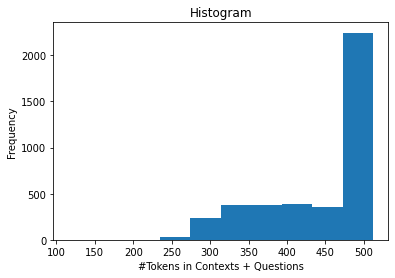

In [ ]:
temp_test_length_list = get_token_nums(temp_test_dataset)

n, bins, patches=plt.hist(temp_test_length_list)
plt.xlabel("#Tokens in Contexts + Questions")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

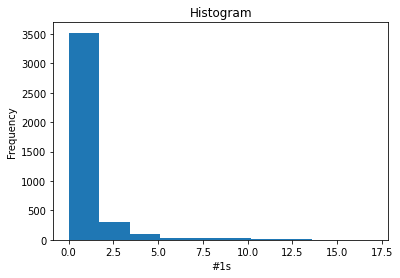

In [ ]:
# unknown tokens
temp_test_one_num_list = get_one_nums(temp_test_dataset)

n, bins, patches=plt.hist(temp_test_one_num_list)
plt.xlabel("#1s")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

#Inference

In [ ]:
def prediction(contexts, questions, guids):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    model.to(device)
    model.eval()
    
    result = []
    
    with torch.no_grad():
        for context, question, guid in zip(contexts, questions, guids):
            encodings = tokenizer(context, question, max_length=512, truncation=True,
                                     padding="max_length", return_token_type_ids=False)
            encodings = {key: torch.tensor([val]) for key, val in encodings.items()}
            
            input_ids = encodings["input_ids"].to(device)
            attention_mask = encodings["attention_mask"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            # TODO: start, end 좌표 활용해서 Baseline 코드처럼 context에서 추출해야 함.
            start_logits, end_logits = outputs.start_logits, outputs.end_logits
            token_start_index, token_end_index = start_logits.argmax(dim=-1), end_logits.argmax(dim=-1)
#             pred_ids = input_ids[0][token_start_index: token_end_index + 1]
#             pred = tokenizer.decode(pred_ids)
#             result.append([guid,pred])
            result.append([guid,token_start_index.cpu().item(), token_end_index.cpu().item()])
#             result.append([token_start_index, token_end_index, pred])

    return result

In [ ]:
pred_idx = prediction(test_contexts, test_questions, test_guids)


# train_length_list = get_token_nums(train_dataset)

# n, bins, patches=plt.hist(train_length_list)
# plt.xlabel("#Tokens in Contexts + Questions")
# plt.ylabel("Frequency")
# plt.title("Histogram")
# plt.show()

#Token 개수 & Unknown token 개수 확인
Token 개수 확인하려면 test dataset 객체 만들어줘야 함 (위에서 KlueDataset 썼던것처럼)

In [ ]:
predictions = []

for pred, context, question in zip(pred_idx, test_contexts, test_questions):
    position = 0
    text = context + '[SEP]' + question
    context_position =[]
    for morph in tokenizer.tokenize(text):
        morph_text_only = morph.replace('#','')
        position = context.find(morph_text_only, position)
#         pdb.set_trace()
        context_position.append((position, position + len(morph_text_only)))
        position += len(morph_text_only)
    
    start = pred[1] - 1
    end = pred[2] - 1
    answer = context[context_position[start][0]: context_position[end][1]]
    
    predictions.append((pred[0], answer))

Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
len(predictions)

4008

#Answers 길이 살펴보기

In [ ]:
predictions

[('d14cb73158624cf094c546d856fd3c80', '뉴 740Li 25주년 에디션'),
 ('906631384e91493ebe1c7f34aea6f241', '독일 뒤셀도르프로'),
 ('35e61dcb479643448a2cb7d326ae50a6', '링크트인과 페이스북'),
 ('075e761b370040cb9041eecd39afc27c', '페이스북'),
 ('e67ed38f3dd944be94d5b4c53731f334', '마드리드'),
 ('80cacfdfe76442b0b39568e8b193d066', '국제 원자재값 하락'),
 ('78a80cca941c46379a5c65b2f1392f7c', '2조6000억원'),
 ('5c19b9781f8a4f0faa9045274c38a8b4', '운영허가 인증서'),
 ('d2844b7141cb4a2594d433e9c1e5cd0c', '성형'),
 ('be39b91f52a04b0aaafc96ff505cb2fc', '노르웨이'),
 ('98fe72c173f642e29f9284f1769fd4f6', '16종'),
 ('1756f8a643124b52aa773a0f38b7b6fa', '필리핀'),
 ('1f1ef695105049079e093bae6f4ad8e7', '김교성'),
 ('acbc4be5f9d04b76a30451f8c6baf277', '79달러'),
 ('393657048abd435b9059b00ed54dcc47', '존 위클리프'),
 ('08ee8dae9f6744cf91d79e0782426d33', '존 위클리프'),
 ('0fd8aca8b9844e3d85e0379272600e3b', '신성 로마 제국의 황제 지기스문트'),
 ('fa773f05fd224cbab0327d1459e38f8a', '복정역'),
 ('89810801a2f446ef9ea0b74cdc478f3c', '내일'),
 ('30a8f6b62fa142209b241d35e308002b', '경희대 음대'),
 ('4957b707

#저장

In [ ]:
results = pd.DataFrame(predictions, columns = ['ID', 'Predicted'])

In [ ]:
results.head()

,ID,Predicted
0,d14cb73158624cf094c546d856fd3c80,뉴 740Li 25주년 에디션
1,906631384e91493ebe1c7f34aea6f241,독일 뒤셀도르프로
2,35e61dcb479643448a2cb7d326ae50a6,링크트인과 페이스북
3,075e761b370040cb9041eecd39afc27c,페이스북
4,e67ed38f3dd944be94d5b4c53731f334,마드리드


In [ ]:
results.to_csv('./klue_bert_wo_split_42_1.csv', index=False)

In [ ]:
from google.colab import files
files.download('./klue_bert_wo_split_42_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#코드 수정 후 (val set 만든 후) 사용
이제 예측한 답과 실제 답을 비교하여 모델의 성능을 평가해보겠습니다.

진행할 평가는 EM(exact match)으로 QA 작업에 가장 일반적으로 사용되는 측정 항목입니다.

예측한 답과 실제 답이 정확히 일치하면 점수를 얻게 됩니다

In [ ]:
# def em_evalutate(prediction_answers, real_answers):
#     total = len(prediction_answers)
#     exact_match = 0
#     for prediction_answer, real_answer in zip(prediction_answers, real_answers):
#         if prediction_answer in real_answer:
#             exact_match += 1
    
#     return (exact_match/total) * 100

In [ ]:
# em_score = em_evalutate(pred_answers, dev_answers)
# em_score